In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from pprint import pprint
from graphviz import Digraph
import uuid


# Load dataset
df = pd.read_csv('/content/sample_data/Decision Tree Dataset.csv')

# Convert categorical values to numeric for processing
for column in df.columns:
    df[column] = df[column].astype('category').cat.codes

# Convert DataFrame to list of records
data = df.values.tolist()
header = df.columns.tolist()


In [ ]:
def entropy(rows):
    labels = [row[-1] for row in rows]
    counts = Counter(labels)
    total = len(rows)
    return -sum((count/total) * np.log2(count/total) for count in counts.values())

In [ ]:
def split(rows, column, value):
    left = [row for row in rows if row[column] == value]
    right = [row for row in rows if row[column] != value]
    return left, right

In [ ]:
def best_split(rows):
    best_gain = 0
    best_question = None
    current_entropy = entropy(rows)
    n_features = len(rows[0]) - 1

    for col in range(n_features):
        values = set(row[col] for row in rows)
        for val in values:
            left, right = split(rows, col, val)
            if not left or not right:
                continue
            p = float(len(left)) / len(rows)
            gain = current_entropy - (p * entropy(left)) - ((1 - p) * entropy(right))
            if gain > best_gain:
                best_gain = gain
                best_question = (col, val)
    return best_gain, best_question


In [ ]:
class Node:
    def __init__(self, question=None, true_branch=None, false_branch=None, prediction=None):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.prediction = prediction
        self.id = str(uuid.uuid4())  # unique ID for graph nodes

def build_tree(rows):
    gain, question = best_split(rows)
    if gain == 0:
        predictions = Counter([row[-1] for row in rows])
        return Node(prediction=predictions)
    col, val = question
    true_rows, false_rows = split(rows, col, val)
    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    return Node(question=(col, val), true_branch=true_branch, false_branch=false_branch)


In [ ]:
def visualize_tree(node, dot=None):
    if dot is None:
        dot = Digraph()

    if node.prediction is not None:
        label = "Predict: " + str(dict(node.prediction))
        dot.node(node.id, label, shape='box', style='filled', color='lightblue')
    else:
        col_name = header[node.question[0]]
        val = node.question[1]
        label = f"{col_name} == {val}?"
        dot.node(node.id, label)

        # True branch
        dot = visualize_tree(node.true_branch, dot)
        dot.edge(node.id, node.true_branch.id, label="True")

        # False branch
        dot = visualize_tree(node.false_branch, dot)
        dot.edge(node.id, node.false_branch.id, label="False")

    return dot


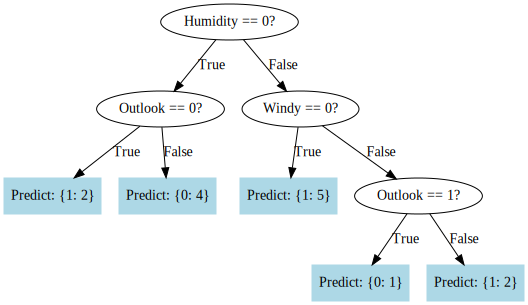

In [ ]:
tree = build_tree(data)
dot = visualize_tree(tree)
dot.render('decision_tree', format='png', cleanup=False)  # Saves as PNG
dot  # Display in Google Colab